# Movie Recommendation System Collaborative Filter

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import time
from sklearn.svm import SVR
import cupy as cp
from numba import cuda
import helper_gpu as hpgpu

In [2]:
cuda.detect()

Found 1 CUDA devices
id 0    b'NVIDIA GeForce GTX 1050'                              [SUPPORTED]
                      Compute Capability: 6.1
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-a153ca43-2bac-7e7e-5575-ebeb58f54b42
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

# Reading Data

In [3]:
query=pd.read_csv("~/Downloads/ml-100k/u5.base",header=None,delimiter="\t",names=["user id", "item id","rating","timestamp"])

In [4]:
query_test=pd.read_csv("~/Downloads/ml-100k/u5.test",header=None,delimiter="\t",names=["user id", "item id","rating","timestamp"])

In [5]:
user=pd.read_csv("~/Downloads/ml-100k/user_full.csv",header=None)

In [6]:
item_2=pd.read_csv("~/Downloads/ml-100k/u.item",header=None,delimiter="|",encoding='ISO-8859-1')

In [7]:
item=pd.read_csv("~/Downloads/ml-100k/item_final.csv")

# Analysis of query

In [8]:
A=cp.zeros((943,1682))
B=cp.asarray(query.iloc[:,0].values)

C=cp.asarray(query.iloc[:,1].values)

D=cp.asarray(query.iloc[:,2].values)

@cuda.jit
def rating_func(A,B,C,D):
    row=cuda.grid(1)
    if row<len(B):
        A[B[row]-1,C[row]-1]=D[row]

rating_func[200,500](A,B,C,D)

rating=cp.asnumpy(A)

del A,B,C,D

rating

array([[5., 3., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Collaborative Filtering

sparse square error:1.5657952352104472 gravity:0.18858163009517126 regularisation:1.8121957709200736 regularisation:1.8159405846627827
Finished in 33.928148859999965 secs


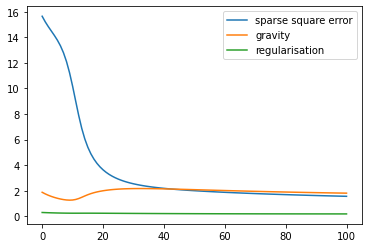

In [9]:
learned_rating=cp.asnumpy(hpgpu.fact_reg_sparse(steps=100,rating=rating,dim=30,gravity=1,weight=0.02,learn_rate=20)[0])

In [10]:
temp1=0
temp2=0
for user_id in user[0].values:
    print(user_id,end="\r")
    X=pd.DataFrame(columns=["item id","score"])
    X["item id"]=[int(i+1) for i in range(rating.shape[1])]
    X["score"]=learned_rating[user_id-1,:]
    reco=hpgpu.recommendation(user_id=user_id,rank_matrix=X,query=query,\
                              length=len(query_test[query_test["user id"]==user_id])\
                              ,score_name="score",itemid_name="item id",userid_name="user id")
    Y=pd.merge(reco,query_test[query_test["user id"]==user_id],how="inner",left_on="item id",right_on="item id")
    temp1=temp1+len(query_test[query_test["user id"]==user_id])
    temp2=temp2+len(Y)
print(temp2/temp1)

0.27495


# Feature Based Collaborative Filtering

## MOVIE features

In [11]:
genre_movie_embedding=item.iloc[:,2:].values

sparse square error:3.7083118001545885 gravity:0.24390390235631698 regularisation:2.0925980023383187 regularisation:2.09253372474601225
Finished in 60.13288227399994 secs


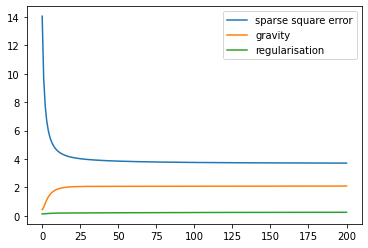

In [12]:
learned_rating=hpgpu.fact_reg_sparse(learn_rate=100,rating=rating,steps=200,\
                                     choice=1,v=np.transpose(genre_movie_embedding),weight=.02,gravity=1)[0]
learned_rating=cp.asnumpy(learned_rating)                                                                                                          

In [13]:
temp1=0
temp2=0
for user_id in user[0].values:
    print(user_id,end="\r")
    X=pd.DataFrame(columns=["item id","score"])
    X["item id"]=[int(i+1) for i in range(rating.shape[1])]
    X["score"]=learned_rating[user_id-1,:]
    reco=hpgpu.recommendation(user_id=user_id,rank_matrix=X,query=query,\
                              length=len(query_test[query_test["user id"]==user_id])\
                              ,score_name="score",itemid_name="item id",userid_name="user id")
    Y=pd.merge(reco,query_test[query_test["user id"]==user_id],how="inner",left_on="item id",right_on="item id")
    temp1=temp1+len(query_test[query_test["user id"]==user_id])
    temp2=temp2+len(Y)
print(temp2/temp1)

0.1052


## USER features

In [14]:
feature=hpgpu.feature_matrix_construct(features=[user[1].unique(),user[2].unique(),user[3].unique(),user[5].unique()],columns_index=[1,2,3,5],df=user)

0...done
1...done
2...done
3...done


In [15]:
feature

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

sparse square error:1.7198675703424529 gravity:0.4132526199949328 regularisation:2.124979311670460346 regularisation:2.1254056900360876
Finished in 67.36765132699998 secs


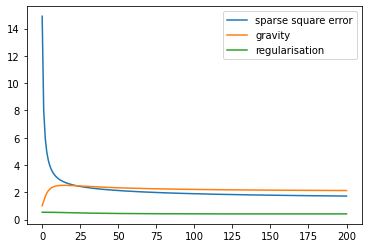

In [16]:
learned_rating=hpgpu.fact_reg_sparse(learn_rate=100,rating=rating,steps=200,\
                                     choice=2,u=feature,weight=.02,gravity=1)[0]
learned_rating=cp.asnumpy(learned_rating) 

In [17]:
temp1=0
temp2=0
for user_id in user[0].values:
    print(user_id,end="\r")
    X=pd.DataFrame(columns=["item id","score"])
    X["item id"]=[int(i+1) for i in range(rating.shape[1])]
    X["score"]=learned_rating[user_id-1,:]
    reco=hpgpu.recommendation(user_id=user_id,rank_matrix=X,query=query,\
                              length=len(query_test[query_test["user id"]==user_id])\
                              ,score_name="score",itemid_name="item id",userid_name="user id")
    Y=pd.merge(reco,query_test[query_test["user id"]==user_id],how="inner",left_on="item id",right_on="item id")
    temp1=temp1+len(query_test[query_test["user id"]==user_id])
    temp2=temp2+len(Y)
print(temp2/temp1)

0.21285
